**Each presentation will last 30 minutes (20 minutes + 10 minutes for questions).**

During the project we expect you to write a report using a Notebook Python (.ipynb, same format as the practical session).
The articles cover several topics we discussed during the courses (Hamiltonian Monte Carlo, Pseudo-Marginal algorithm, variational inference). Each report is expect to contain (at least):

- A description of the context of the article (model, specific challenge and objective of the algorithm).

- A clear description of the algorithm introduced in the paper with a discussion on its specificities (tuning parameters, etc.) with respect to the algorithm we studied during the courses.

- Numerical illustrations of the algorithm at least on a simulated dataset (with discussion on its performance). 

Note that the papers do not contain the same level of technicalities. To select the project read carefully the abstract and introduction to choose according to your affinities about the algorithms and their objectives. For the most complex papers, we do not expect you to rewrite all the proofs and understand all technical details.

Group 13 - Project 5  
Lotfi Kobrosly, Yuhe Bai, Pierre-André Mikem and Nawel Arab  
**Tuesday 15th December 10h30** -  Project 10 &  Project 5 


# Introduction




In [1]:
import scipy.io as sio
import random
from scipy.sparse import coo_matrix
import numpy as np
import time
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# PULA

**This python function implements the proximal unadjusted Langevin algorithm described in**  
[1] M. Pereyra, "Proximal Markov chain Monte Carlo algorithms," submitted to Journal Royal Statistics Society: Series B.  
E-print available on Arxiv: http://arxiv.org/abs/1306.0187  
**Inputs**  
- X0 : initial state of the Markov chain
- proxg : function handler of type @(X,lambda) for the lambda-proximity mapping of g(x) = \log\pi(x)
- options (stucture) 

  **Required**:    
  - options.samples : number of output samples
  - options.delta : initial value of the time-discretisation step(this value may be adapted during the burn-in period to improve the acceptance rate)

  **Optional**:  
  - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)  
  - options.display    : display progressbar (1) do not display (0)

**Outputs**
- Xchain : Makov chain generated by P-ULA 
- time : cpu time

In [2]:
def pula(X0=None,proxg=None,options=None):
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
  n = X0.shape # gives num of rows and cols of X0
  Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 

  # Initialize variables
  delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
  Xcur = X0               # set initial state as current state
  
  if n[1]==1:
    Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
  else:
    Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #  progressbar

  time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
  for ii in range(1, int(options['samples'] * options['thinning'])):
    # Prox-point Proposal
    Xcur = proxg(Xcur, delta/2) + np.sqrt(delta)*np.random.randn(1,1)
    
    # Save sample (with thinning)
    if not np.mod(ii,options['thinning']):
      if n[1]==1:
        Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
      else:
        Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    
  time_s = time.time()-time_start
  return Xchain,time_s




# PMALA

**This python function implements the proximal unadjusted Langevin algorithm described in**  
[1] M. Pereyra, "Proximal Markov chain Monte Carlo algorithms," submitted to Journal Royal Statistics Society: Series B.  
E-print available on Arxiv: http://arxiv.org/abs/1306.0187  
**Inputs**  
- X0 : initial state of the Markov chain
- proxg : function handler of type @(X,lambda) for the lambda-proximity mapping of g(x) = \log\pi(x)
- options (stucture) 

  **Required**:    
  - options.samples : number of output samples
  - options.delta : initial value of the time-discretisation step(this value may be adapted during the burn-in period to improve the acceptance rate)

  **Optional**:  
  - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)  
  - options.display    : display progressbar (1) do not display (0)
  - options.burnIn     : number of burn-in iterations
  - options.targetRate : desired acceptance rate
  - options.updateDelta: the value of delta is adjuted every 'options.updateDelta' iterations (during the burn-in period). Adaptation is disabled by setting options.updateDelta = 0

**Outputs**
- Xchain : Makov chain generated by P-ULA 
- gTrace : trace of g(X)
- acceptTrace : trace of accepted moves
- time : cpu time
- delta : final value of delta after the burn-in adaptation

In [3]:
def pmala(X0=None,g=None,proxg=None,options=None):
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
  n = X0.shape # gives num of rows and cols of X0
  Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 
  #print(Xchain.shape)
  gTrace = np.zeros(int(options['samples'] * options['thinning']))  
  acceptTrace = np.zeros(int(options['samples'] * options['thinning'])) 

  # Initialize variables
  delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
  Xcur = X0               # set initial state as current state
  proxgXcur = proxg(Xcur,delta/2)    # pre-compute proxg(Xcur)
  gXcur=g(Xcur)              # pre-compute g(Xcur)
  gTrace[0]=gXcur             # record value g(Xcur) as a scalar summary
  if n[1]==1:
    Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
  else:
    Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # Set the appropriate norm for 'X'
  if n[1]==1:
    p = 2      # L2 norm (X is in vector form)
  else:
    p = 'fro'  # Frobenius (X is in matrix form)
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #   progressbar

  time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
  for ii in range(1, int(options['samples'] * options['thinning'])):
    # Generate candidate using P-ULA proposal
    Xnew = proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1]) # may be changed
    
    # Compute Metropolis-Hastings ratio: target ratio
    gXnew = g(Xnew)
    logPiRatio = gXnew - gXcur
    # Compute Metropolis-Hastings ratio: proposal ratio
    proxgXnex = proxg(Xnew,delta/2)
    logPropRatio = (np.linalg.norm(Xnew - proxgXcur,p)**2 - np.linalg.norm(Xcur - proxgXnex,p)**2)/(2*delta);
    
    # Accept-Reject candidate
    if np.log(np.random.rand(1)) < (logPiRatio + logPropRatio):
      Xcur = Xnew;                # set candidate as new current
      acceptTrace[ii]=1               # record that the candidate was accepted
      proxgXcur = proxgXnex           # record proxg(Xnew) for next iteration
      gXcur = gXnew              # record g(Xnew) for next iteration
    # Record value g(Xcur) as a scalar summary
    gTrace[ii] = gXcur
    
    # Record sample (with thinning)
    if not np.mod(ii,options['thinning']):
      if n[1]==1:
        Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
      else:
        Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    # Adapt the value of delta to achieve an appropriate acceptance rate (only during burn-in period)
    if options['updateDelta']:
      if ii < options['burnIn']*options['thinning']:
        if not np.mod(ii,options['updateDelta']):
                
          # Estimate acceptance probability over the last
          # 'options.updateDelta' iterations
          accRate = np.mean(acceptTrace[int(ii-options['updateDelta']): int(ii)])
                
          # If accRate is 1% higher than targetRate increase delta
          # by 25%, otherwise if 1% lower decrease by 20%.
          if accRate>options['targetRate']*1.01:
            delta = delta*1.25
          elif accRate<options['targetRate']/1.01:
            delta = delta*0.8


    
  time_s = time.time()-time_start
  return Xchain,gTrace,acceptTrace,time_s,delta




In [4]:
# test
# pmala(X0,g1,proxg1,options)

# Demo_pula_illustrativeExample
In this section, we implemented illustrative examples of the "proximal unadjusted Langevin algorithm" (P-ULA): 4 univariate distibutions with different tails

- 1 Simulate from univariate Laplace distribution
- 2 Simulate from univariate Gaussian distribution
- 3 Simulate from univariate quartic (4th order polynomial) distribution
- 4 Simulate from univariate uniform  distribution

The first step is to define the 4 different proximity mapping functions for 4 univariate distributions. 

The second step is to set up the sampler. In our examples, it is easy to see that the specific form of the distribution depends on the probability mapping function, see later in detail. We set up a sampler as follows: 
    - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)
    - options.samples : total number of samples
    - options.delta : value of time-discretisation step "delta"


## 1 - Simulate from univariate Laplace distribution

In this distribution, we define the proximity mapping as follows:
$$\operatorname{proxg}_{1}(x)=\operatorname{sign}(x) *(\max (a b s(x), \lambda)-\lambda)$$


- options.samples is 110,000 which is the total number of samples.
- options.thinning is 1. That is, the number of iterations for each sample is 1, because we only consider the one-dimensional situation here.
- options.delta is 0.02. The minimum interval length after time discretization is 0.02
 
Through the P-ULA algorithm, we can obtain a Markov chain with a sample length. Taking into account the instability in the random process, we take the remaining samples after calculating 10,000 samples as the representation of the steady-state distribution.

running time:  2.489936113357544


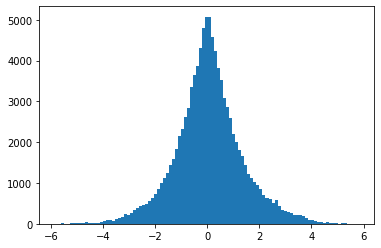

In [37]:
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
    return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
X0 = np.matrix(np.random.rand(1, 1)) # set initial state

# Run P-ULA
Xchain1,time_s1 = pula(X0,proxg1,options)
Xchain1 = Xchain1.reshape(Xchain1.shape[0],Xchain1.shape[1])
print('running time: ',time_s1)
plt.hist(Xchain1[10000:],101)
plt.show()

## 2 - Simulate from univariate Gaussian distribution

In this distribution, we define the proximity mapping as follows:
$$\operatorname{proxg}_{2}(x)= \frac{x}{(1+\lambda)}$$


running time:  0.7830934524536133


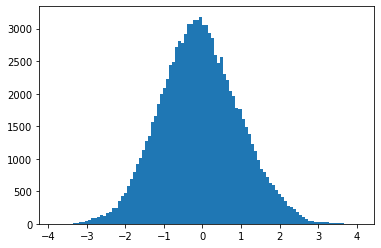

In [45]:
# Define proximity mapping of g(x) = log\pi(x)
def proxg2(X, lamda):
    return X/(1+lamda)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.random.rand(1, 1) # set initial state

# Run P-ULA
Xchain2,time_s2 = pula(X0,proxg2,options)
Xchain2 = Xchain2.reshape(Xchain2.shape[0],Xchain2.shape[1])
print('running time: ',time_s2)
plt.hist(Xchain2[10000:],101)
plt.show()

## 3 - Simulate from univariate quartic (4th order polynomial) distribution

In this distribution, we define the proximity mapping as follows:
$$\operatorname{proxg}_{3}(x)=\frac{p}{3 l^{\frac{1}{3}}}-l^{1/3}$$
Where 
$$l=\frac{\left(\sqrt{q^{2}-\frac{4}{27} p^{3}}-q\right)}{2}$$
And 
$$p=\frac{1}{4} \lambda, q=\frac{x}{4} \lambda$$

running time:  1.6438403129577637


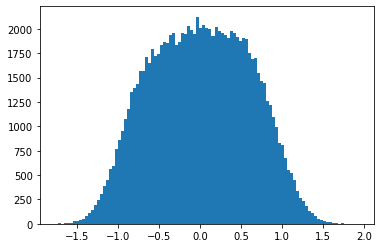

In [33]:
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
    p = 1.0/(4.*lamda)
    q = 1.0*X/(4.*lamda)
    w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
    w = pow(w3, (1./3))
    u = p/(3.*w) - w
    return u

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.random.rand(1, 1) # set initial state
# Run P-ULA
Xchain3, time_s3 = pula(X0,proxg3,options)
Xchain3 = Xchain3.reshape(Xchain3.shape[0],Xchain3.shape[1])
print('running time: ',time_s3)
plt.hist(Xchain3[10000:],101)
plt.show()

## 4 - Simulate from univariate uniform  distribution
In this distribution, we define the proximity mapping as follows:
$$\operatorname{prox}_{4}(x)=\min (\max (x,-0.5), 0,5)$$

running time:  0.9185178279876709


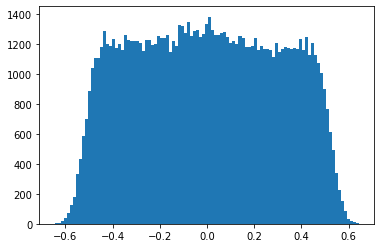

In [34]:
# Define proximity mapping of g(x) = log\pi(x)
def proxg4(X, lamda):
    return min(max(-1/2,X),1/2)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.002 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.random.rand(1, 1) # set initial state

# Run P-ULA
Xchain4, time_s4 = pula(X0,proxg4,options)
Xchain4 = Xchain4.reshape(Xchain4.shape[0],Xchain4.shape[1])
print('running time: ',time_s4)
plt.hist(Xchain4[10000:],101)
plt.show()

## Display results


Running time for univariate Laplace distribution:  2.489936113357544
Running time for univariate Gaussian distribution:  0.7957272529602051
Running time for univariate quartic (4th order polynomial) distribution:  1.6438403129577637
Running time for univariate uniform  distribution:  0.9185178279876709


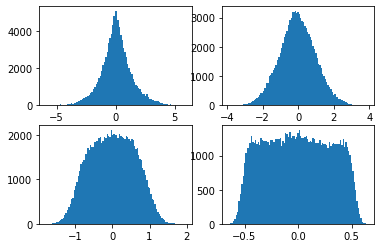

In [40]:
# Run P-ULA
plt.subplot(2,2,1)
plt.hist(Xchain1[10000:],101)

plt.subplot(2,2,2)
plt.hist(Xchain2[10000:],101)

plt.subplot(2,2,3)
plt.hist(Xchain3[10000:],101)

plt.subplot(2,2,4)
plt.hist(Xchain4[10000:],101)
print('Running time for univariate Laplace distribution: ',time_s1)
print('Running time for univariate Gaussian distribution: ',time_s2)
print('Running time for univariate quartic (4th order polynomial) distribution: ',time_s3)
print('Running time for univariate uniform  distribution: ',time_s4)
plt.show()


# Demo_pmala_illustrativeExample
In this section, we implemented illustrative examples of the "proximal Metropolis adjusted Langevin algorithm" (P-MALA): 4 univariate distibutions with different tails

- 1 Simulate from univariate Laplace distribution
- 2 Simulate from univariate Gaussian distribution
- 3 Simulate from univariate quartic (4th order polynomial) distribution
- 4 Simulate from univariate uniform  distribution

These distributions are as follows:
$$\pi_{1}(x)=e^{-|x|}$$
$$\pi_{2}(x)=e^{-x^{2} / 2}$$
$$\pi_{3}(x)=e^{-x^{4}}$$
$$\pi_{4}(x)=\operatorname{double}(\operatorname{abs}(\mathrm{x})<0.5)$$

The first step is to define the 4 different distributions and their related different proximity mapping functions for 4 univariate distributions. 

The second step is to set up the sampler. We set up a sampler as follows: 
    - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)
    - options.samples : total number of samples
    - options.delta : value of time-discretisation step "delta"
    - options.targetRat : target an acceptance probability 
    - options.updateDelta : adjust the value of delta every updateDelta iterations
    - options.burnIn : adjust the value of delta only during the first burnIn iterations

## 1 - Simulate from univariate Laplace distribution

This distribution is as follows:
$$g_{1}(x)=\log \pi_{1}(x)=-|x|$$
In this distribution, we define the proximity mapping as follows:
$$\operatorname{proxg}_{1}(x)=\operatorname{sign}(x) *(\max (a b s(x), \lambda)-\lambda)$$


running time:  10.186736345291138


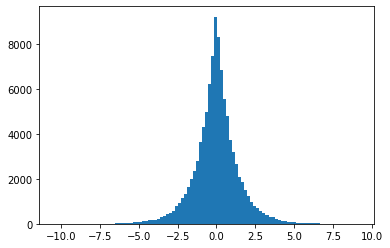

In [46]:
# Define g = \log\pi(x)
def g1(X):
    return -np.abs(X)
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
    #print(np.sign(X),np.abs(X),lamda)
    return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.matrix(np.random.rand(1, 1)) # set initial state
# Run P-MALA
Xchain1,gTrace1,acceptTrace1,time_s1,delta1 = pmala(X0,g1,proxg1,options)
Xchain1 = Xchain1.reshape(Xchain1.shape[0],Xchain1.shape[1])
print('running time: ',time_s1)
plt.hist(Xchain1[10000:],101)
plt.show()


## 2 - Simulate from univariate Gaussian distribution
This distribution is as follows:
$$g_{2}(x)=\log \pi_{2}(x)=-\frac{x^{2}}{2}$$
In this distribution, we define the proximity mapping as follows:
$$\operatorname{proxg}_{2}(x)= \frac{x}{(1+\lambda)}$$


running time:  6.815539836883545


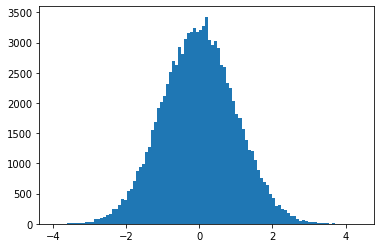

In [47]:
# Define g = \log\pi(x)
def g2(X):
    return -0.5 * pow(X,2)
# Define proximity mapping of g(x) = log\pi(x)
def proxg2(X, lamda):
    return X/(1+lamda)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
Xchain2,gTrace2,acceptTrace2,time_s2,delta2 = pmala(X0,g2,proxg2,options)
Xchain2 = Xchain2.reshape(Xchain2.shape[0],Xchain2.shape[1])
print('running time: ',time_s2)
plt.hist(Xchain2[10000:],101)
plt.show()

## 3 - Simulate from univariate quartic (4th order polynomial) distribution
This distribution is as follows:
$$g_{3}(x)=\log \pi_{3}(x)=-x^{4}$$
In this distribution, we define the proximity mapping as follows:
$$\operatorname{proxg}_{3}(x)=\frac{p}{3 l^{\frac{1}{3}}}-l^{1/3}$$
Where 
$$l=\frac{\left(\sqrt{q^{2}-\frac{4}{27} p^{3}}-q\right)}{2}$$
And 
$$p=\frac{1}{4} \lambda, q=\frac{x}{4} \lambda$$

running time:  7.868729114532471


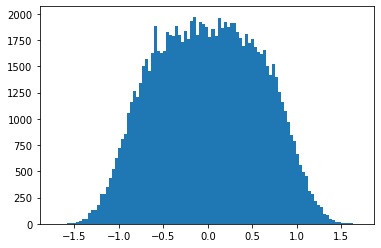

In [48]:
# Define g = \log\pi(x)
def g3(X):
    return -pow(X,4)
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
    p = 1.0/(4.*lamda)
    q = 1.0*X/(4.*lamda)
    w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
    w = pow(w3, (1./3))
    u = p/(3.*w) - w
    return u

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
Xchain3,gTrace3,acceptTrace3,time_s3,delta3 = pmala(X0,g3,proxg3,options)
Xchain3 = Xchain3.reshape(Xchain3.shape[0],Xchain3.shape[1])
print('running time: ',time_s3)
plt.hist(Xchain3[10000:],101)
plt.show()

## 4 - Simulate from univariate uniform  distribution
This distribution is as follows:
$$g_{4}(x)=\log \pi_{4}(x)=\log \text { double }(\operatorname{abs}(x)<0.5)$$

In this distribution, we define the proximity mapping as follows:
$$\operatorname{prox}_{4}(x)=\min (\max (x,-0.5), 0,5)$$

C:\Users\Cecile\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


running time:  7.133970022201538


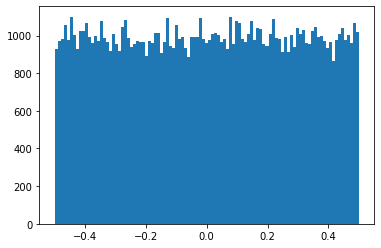

In [49]:
# Define g = \log\pi(x)
def g4(X):
    return np.log(np.double(abs(X)<0.5))
# Define proximity mapping of g(x) = log\pi(x)
def proxg4(X, lamda):
    return min(max(-1/2,X),1/2)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1)/2 -1/2 # set initial state
# Run P-MALA
Xchain4,gTrace4,acceptTrace4,time_s4,delta4 = pmala(X0,g4,proxg4,options)
print('running time: ',time_s4)
Xchain4 = Xchain4.reshape(Xchain4.shape[0],Xchain4.shape[1])
plt.hist(Xchain4[10000:],101)
plt.show()

## Display results


Running time for univariate Laplace distribution:  10.186736345291138
Running time for univariate Gaussian distribution:  6.815539836883545
Running time for univariate quartic (4th order polynomial) distribution:  7.868729114532471
Running time for univariate uniform  distribution:  7.133970022201538


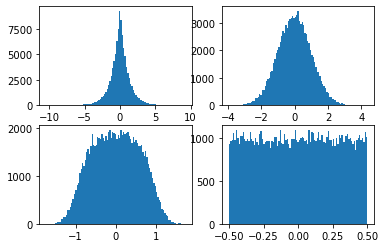

In [50]:
# Run P-MALA
plt.subplot(2,2,1)
plt.hist(Xchain1[10000:],101)

plt.subplot(2,2,2)
plt.hist(Xchain2[10000:],101)

plt.subplot(2,2,3)
plt.hist(Xchain3[10000:],101)

plt.subplot(2,2,4)
plt.hist(Xchain4[10000:],101)

print('Running time for univariate Laplace distribution: ',time_s1)
print('Running time for univariate Gaussian distribution: ',time_s2)
print('Running time for univariate quartic (4th order polynomial) distribution: ',time_s3)
print('Running time for univariate uniform  distribution: ',time_s4)
plt.show()


## Discussion on performance
- P-ULA is much faster than P-MALA
- P-MALA seems to have better results than P-ULA

# Implementation on 2 other datasets
## On audio data

## Demo_pmala_audioCS

In this section, We implemented "proximal Metropolis adjusted Langevin algorithm" (P-MALA) to the audio compressive sensing experiment "Mary had a little lambd" in a MIDI representation.

The work is as followings：

1) calculate alpha which is the parameter of the distribution for the samples, which are defined by the notes and frequencies in the music. 

2) implemente the P-MALA algorithm to sample the notes in the music.



## createDictionary

In [5]:
# This python function generates a dictionary representing piano notes
# Adapted from Laura Balzano, Robert Nowak and Jordan Ellenberg http://sunbeam.ece.wisc.edu/csaudio/

def createDictionary():
  
    fs = 44100           # Sampling frequency
    t = np.arange(0,0.25,1/fs)       # Time points of each sample in a quarter-second note
    T = len(t)          # Number of samples in a note
    M = 29             # Number of notes in Mary Had a Little Lamb.
    allfreqs = [16.35, 17.32, 18.35, 19.45, 20.6, 21.83, 23.12, 24.5, 25.96, 27.5, 29.14, 30.87, 
              32.7, 34.65, 36.71, 38.89, 41.2, 43.65, 46.25, 49, 51.91, 55, 58.27, 61.74, 65.41, 
              69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, 110, 116.54, 123.47, 130.81, 
              138.59, 146.83, 155.56, 164.81, 174.61, 185, 196, 207.65, 220, 233.08, 246.94, 
              261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.3, 440, 466.16, 
              493.88, 523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 
              880, 932.33, 987.77, 1046.5, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 
              1567.98, 1661.22, 1760, 1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, 2637.02, 
              2793.83, 2959.96, 3135.96, 3322.44, 3520, 3729.31, 3951.07, 4186.01, 4434.92, 4698.64, 4978.03]
    #print(allfreqs)
  
    df = 15; # This is the rate of decay of the note.
    sf = 15; # This is the rate of growth at the beginning of the note.
    
    # Dictionary with vectors used to reconstruct the MIDI song. 
    # There are 29 notes in the song, and each could be in any position in time
    
    I=np.zeros(T*len(allfreqs)*M); # Row indices
    J=np.zeros(T*len(allfreqs)*M); # Column indices
    S=np.zeros(T*len(allfreqs)*M); # The matrix value at that index.
    inds=range(T)
    biter=0;
    print(T)
    
    for fiter in range (len(allfreqs)):
        for k in range (M):
            I[inds] = np.ones((1,T))*biter
            J[inds] = range((k*T),(k+1)*T)
            S[inds] = (1+np.exp(-df*t[-1])-np.exp(-sf*t))*np.exp(-df*t)*(np.sin(2*np.pi*allfreqs[fiter] * t))
            biter=biter+1
            inds = np.array(inds)+T
    #print(I.max())
    Phi = np.transpose(coo_matrix((S,(I,J)),shape = (len(allfreqs)*M,M*T))) # Store matrix in sparse format
    print(Phi.shape)
    return Phi

In [6]:
# Load data
# z - MIDI interpretation of the 'Mary had a little lamb' medoly 
# containing 319725 samples
# sig2 - value of sigma^2 (2.2500e-04)
import scipy.io as sio
audio_data = sio.loadmat('data/audioCSdata.mat')
z = audio_data['z']
sig2 = audio_data['sig2']
n = z.size
print(z.shape)
print(sig2)

(319725, 1)
[[0.000225]]


In [7]:
# Experiment setup
# Create matrix Psi: subsampling operator that collects k random entries of z
import random
from scipy.sparse import coo_matrix
import numpy as np
k = 456 # number of samples
ii = sorted(random.sample(range(n),k)) # divide randomly into 456 samples, different length，ii is their index
# the kth ii of the kth line is 1, 456 1s in total
Psi = coo_matrix((np.ones(k), (range(k), ii)), shape=(k,n)) # toarray() 456*319725
print(len(ii))
#print(Psi)
# Create matrix Phi: dictionary with piano notes providing a sparse representation for MIDI signals
Phi = createDictionary()

# Observation vector (i.e., sample random entries of z)
y = Psi @ z # cannot use np.dot , 456*1
#print(y)
# Regressor matrix
A = Psi @ Phi #456*2900
# Setup EM
K = 30    # number of EM iterations
M0 = 1e4   # number of burn-In iteration per EM iteration
M  = 1e4   # number of samples after burn-in per EM iteration

# Allocate alpha chain
alpha = np.zeros(K)

# Inialise alpha using the heuristic 0.1||Phi^T*Psi^T*y||_\infty||/sig2
alpha[0] = 0.1*np.abs(A.T @ y).max()/sig2
print(alpha[0])


456
11025
(319725, 2900)
175.2691177936975


In [8]:
# Compute MAP estimate with alpha[0]
x_MAP = audio_data['x_MAP']

# Compute mean square error     
MSE = np.linalg.norm(Phi @ x_MAP-z)**2/z.size;
print(MSE)

# Monte Carlo EM algorithm
#time_start=time.time()
for jj in range (1,K+1):
    
    # Setup P-MALA
    
    # Setup handler for g(x) = \log\pi(x) with value alpha(jj-1)
    def g(x):
        return -(np.linalg.norm(y-A @ x,2)**2)/(2*sig2) - alpha[jj-1]*np.linalg.norm(x,1)
    
    # Setup handler for proximity mapping of g1(x) = -alpha*norm(x,1)
    def proxg1(x, lamda):
        return np.sign(x)*(np.maximum(np.abs(x),alpha[jj-1]*lamda)-alpha[jj-1]*lamda)
    
    # Setup handler for gradient mapping of g2(x) = -(norm(y-A*x,2)^2)/(2*sig2)
    def grad2(x):
        #print(x.shape)
        return - A.T @ (A@x-y) / sig2
    
    # Setup handler for proximity mapping of g(x) approximated by forward-backward splitting
    def proxg(x,lamda):
        return proxg1(x+lamda*grad2(x),lamda)
    
    options = {}
    options['samples'] = M0+M # total number of samples
    options['burnIn'] = M0 # number of burn-in iterations
    options['updateDelta'] = M0/20 # adjust delta 20 times during the burn-in
    options['thinning'] = 1 # 
    options['targetRate'] = 0.5

    if jj==1:
        options['delta'] = 1e-7 # Set delta
        X0 = x_MAP # use MAP estimate as initial state for 1st EM iteration
    else:
        options['delta'] = delta #use delta from previous iteration
        X0 = Xchain[-1,:] # use last sample from previous iteration as initial state

    # Run P-MALA
    Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g,proxg,options);
    #print(Xchain.shape)
    
    # EM update of alpha
    E = 0;
    for ii in range (int(M)):
        E = E + np.linalg.norm(np.squeeze(Xchain[int(M0+ii),:]),1)/M;
        
    #print(E)
    alpha[jj-1] = X0.size/E;
    
    # Print value of alpha
    #print('epoch')
    print('alpha(',jj,')= ', alpha[jj-1]);
#time_s=time.time()-time_start
#print('running time: ', time_s)
#x2_MAP = audio_data['x2_MAP']

0.002176674140395841
25.85602697137743
alpha( 1 )=  112.15953646746634
113.81468803049763
alpha( 2 )=  25.480015366935064
718.9801575516649
alpha( 3 )=  4.033491007422705
1473.6666562593693
alpha( 4 )=  1.96788058390431
2058.1623090816697
alpha( 5 )=  1.409023956567327
2475.635023722407
alpha( 6 )=  1.17141661521637
2846.4826114806765
alpha( 7 )=  1.0188012350061344
3153.425438037389
alpha( 8 )=  0.9196348722945819
3352.5428842543124
alpha( 9 )=  0.8650150348919492
3627.1425876210587
alpha( 10 )=  0.7995274323919063
3883.504416445677
alpha( 11 )=  0.7467482173366972
4075.439014748353
alpha( 12 )=  0.7115797806090018
4306.0327594909495
alpha( 13 )=  0.6734737429965192
4503.570099314955
alpha( 14 )=  0.6439335762623354
4706.774708689503
alpha( 15 )=  0.6161331653809792
4879.2132202184575
alpha( 16 )=  0.5943581206869574
5042.3312604074845
alpha( 17 )=  0.5751307976869499
5264.273475278514
alpha( 18 )=  0.5508832346227172
5432.562522706052
alpha( 19 )=  0.5338180624482644
5610.49058252308

## Display results

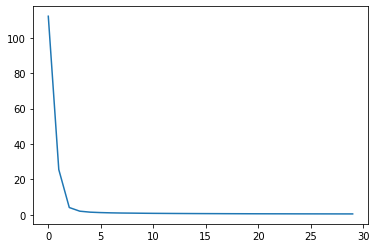

In [9]:
plt.plot(alpha)

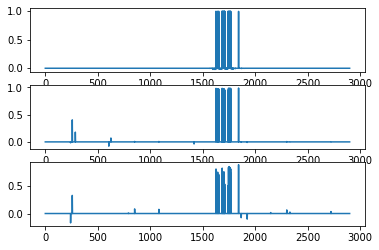

In [11]:
plt.subplot(3,1,1)
plt.plot(np.transpose(Phi)@ z/134) # normalization

x2_MAP = audio_data['x2_MAP']
plt.subplot(3,1,2)
plt.plot(x2_MAP)

plt.subplot(3,1,3)
plt.plot(x_MAP)

In this figure, 
- the first one is the sampled data by our algorithm 
- the second one is EBayes MAP estimate
- the third one is Heuristic MAP estimate

We can consider the second and third figures as an evaluation index, to evaluate if our algorithm worked well.

We can see that we obtained almost the same results than the other 2, which means that our P-MALA algorithm is good.

## Demo_diabetes

In this section, we implemented "proximal unadjusted Langevin algorithm" (P-ULA) and "proximal Metropolis adjusted Langevin algorithm" (P-MALA) to the diabetes data of 
*Efron, B., Hastie, T., Johnstone, I. & Tibshirani, R. (2004), "Least angle regression", Ann. Statist. 32(2), 407-499.*

In this data set, we studied the height, weight, in total 10 attributes of 442 diabetic people, and then obtained their predicted values through the regression model. In our code, we extracted this pre-processed model and sampled it through P-ULA and P-MALA algorithms.

10
running time PULA:  2.5031981468200684
running time PMALA:  16.334031105041504
(110000, 10, 1)


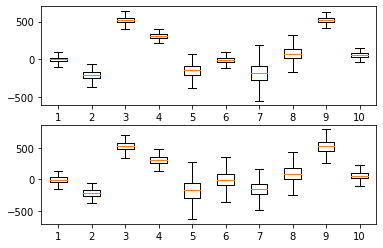

In [ ]:
# Illustrative example: Bayesian lasso
# Application of "proximal unadjusted Langevin algorithm" (P-ULA) and "proximal Metropolis adjusted Langevin algorithm" (P-MALA) 
# [1] to the diabetes data of Efron, B., Hastie, T., Johnstone, I. & Tibshirani, R. (2004), "Least angle regression", Ann. Statist. 32(2), 407-499.

# Load data
# y  - observation vector with responses to treatment
# A  - regressor matrix
# sigma2 - maximum marginal likelihood estimate of hyper-parameter \sigma^2
# alpha  - maximum marginal likelihood estimate of hyper-parameter \alpha

import scipy.io as sio
diabetes_data = sio.loadmat('data/diabetesData.mat')
y = diabetes_data['y']
A = diabetes_data['A']
sigma2 = diabetes_data['sigma2']
alpha = diabetes_data['alpha']

# Setup P-ULA and P-MALA

# Setup handler for g(x) = \log\pi(x)
def g(x):
    # print((y-np.dot(A,x)).shape)
    # print(np.linalg.norm(y-np.dot(A,x),ord=2)^2)
    return -(np.linalg.norm(y-np.dot(A,x),2)**2)/(2*sigma2) -alpha*np.linalg.norm(x,1)

# Setup handler for proximity mapping of g1(x) = -alpha*norm(x,1)
def proxg1(x,lamda):
    #print(np.maximum(np.abs(x),alpha*lamda))
    return np.sign(x)*(np.maximum(np.abs(x),alpha*lamda)-alpha*lamda)
                  
# Setup handler for gradient mapping of g2(x) = -(norm(y-A*x,2)^2)/(2*sig2)
def gradg2(x):
    return -np.dot(np.transpose(A),(np.dot(A,x)-y))/sigma2

# Setup handler for proximity mapping of g(x) approximated by forward-backward splitting
def proxg(x,lamda):
    return proxg1(x+lamda*gradg2(x),lamda)

# Simulate from the posterior \pi(X|Y) using the proximal-point MALA
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = sigma2/3 # value of time-discretisation step "delta"
options['display'] = 1 # do not display progressbar
options['updateDelta'] = 20 # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
options['targetRate']=0.5
X0 = np.zeros((10,1)) # set initial state
print(np.size(X0))
# Run P-ULA
XchainPULA,timePULA = pula(X0,proxg,options)
print('running time PULA: ', timePULA)

# Run P-MALA
XchainPMALA,gTrace,acceptTrace,timePMALA,delta = pmala(X0,g,proxg,options)
print('running time PMALA: ', timePMALA)

print(XchainPULA.shape)
begin = int(options['burnIn'])
medPULA  = np.median(XchainPULA[begin:,:],axis=0)
medPMALA = np.median(XchainPMALA[begin:,:],axis=0)
p05PULA = np.quantile(XchainPULA[begin:,:],0.05,axis=0)
p95PULA  = np.quantile(XchainPULA[begin:,:],0.95,axis=0)
p05PMALA = np.quantile(XchainPMALA[begin:,:],0.05,axis=0)
p95PMALA = np.quantile(XchainPMALA[begin:,:],0.95,axis=0)
XchainPULA = XchainPULA[begin:,:].reshape(XchainPULA.shape[0]-begin,XchainPULA.shape[1])
XchainPMALA = XchainPMALA[begin:,:].reshape(XchainPMALA.shape[0]-begin,XchainPMALA.shape[1])
plt.subplot(2,1,1)
plt.boxplot(XchainPULA,showfliers = False)
plt.subplot(2,1,2)
plt.boxplot(XchainPMALA,showfliers = False)
plt.show()


The figure shows the 10 dimensions of the diabetes data set, and the data sampled in each dimension gets a box diagram.
We can see that P-ULA and P-MALA get the same box diagram which reprents the mean, 1/4, 3/4 results, max and min etc of the 10 attributes of the samples.

P-ULA runs faster than P-MALA